In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/bensonmanner/Desktop/ACME/WebbResearch/Projects/Optimization/delay-optimizer')
import os
import json
from hyperparameter_optimization import generate_learning_rates
from Optimizer_Scripts.param_optimizer_helper import test_builder
from Optimizer_Scripts import Delayer
from Optimizer_Scripts import optimizers 
from Optimizer_Scripts import functions

# Fake Test

In [2]:
def f(x):
    return 4*x*(1-x)

def f_del(x,x_prev):
     return 4*x*(1-x_prev)

def fake_test():
    """
    This function is created to run the test that Dr. Webb devised for looking at how time delays affects
    functional spaces f(x_k, x_{k-1}) = 4*x_k * (1 - x_{k-1})
    """
    #intialize matrices and grid points
    x_grid = np.linspace(0,1,200)
    points_normal = np.zeros(size = (len(x_grid), len(x_grid)))
    points_delayed = np.zeros(size = (len(x_grid), len(x_grid)))
    #now begin the loop
    for x_start in x_grid:
        x_prev = x_start
        x = f(x_prev)
    return None

# Generic - Equal Parameter Values

In [3]:
def get_loss(loss_name, dim):
    if (loss_name == 'Rastrigin'):
        objective = functions.rastrigin_gen(dim)
        gradient = functions.rast_deriv_gen(dim)
    elif (loss_name == 'Ackley'):
        objective = functions.ackley_gen(dim)
        gradient = functions.ackley_deriv_gen(dim)
    return objective, gradient
    
def get_optimizer(optimizer_name, learning_rate, const_lr, optim_params=None):
    params = dict()
    if (optimizer_name == 'gradient'):
        #create learning rate generator
        if (const_lr is True):
            parms = {'learning_rate': learning_rate}
        else:
            parms = {'min_learning_rate': learning_rate[0], 
                     'max_learning_rate': learning_rate[1], 
                     'step_size': learning_rate[2]}
        params['learning_rate'] = generate_learning_rates(const_lr, parms)
        optimizer = optimizers.GradientDescent(params)
    elif (optimizer_name == 'momentum'):
        #create learning rate generator
        if (const_lr is True):
            parms = {'learning_rate': learning_rate}
        else:
            parms = {'min_learning_rate': learning_rate[0], 
                     'max_learning_rate': learning_rate[1], 
                     'step_size': learning_rate[2]}
        params['learning_rate'] = generate_learning_rates(const_lr, parms)
        params['gamma'] = optim_params['gamma']
        optimizer = optimizers.Momentum(params)
    elif (optimizer_name == 'adam'):
        #create learning rate generator
        if (const_lr is True):
            parms = {'learning_rate': learning_rate}
        else:
            parms = {'min_learning_rate': learning_rate[0], 
                     'max_learning_rate': learning_rate[1], 
                     'step_size': learning_rate[2]}
        params['learning_rate'] = generate_learning_rates(const_lr, parms)
        params['beta_1'] = optim_params['beta_1']
        params['beta_2'] = optim_params['beta_2']
        optimizer = optimizers.Adam(params)
    else:
        raise ValueError("Optimizer type not yet compatible")
    return optimizer
                
def get_delayer_class(loss_name='Rastrigin', learning_rate=0.5, max_delay=1, 
                      dim=100, optimizer='gradient', const_lr=True, 
                      optim_params=None):
    objective, gradient = get_loss(loss_name, dim)
    Optimizer = get_optimizer(optimizer, learning_rate, const_lr, optim_params=optim_params)
    time_delayed_optimizer = Delayer.Delayer(dim, Optimizer, objective, gradient,
                                     max_L=max_delay, save_grad=True, logging=True,
                                      num_delays=5000)
    return time_delayed_optimizer

def run_test(X_init, loss_name='Rastrigin', learning_rate=0.5, max_delay=1, 
             dim=100, optimizer='gradient', const_lr=True, optim_params=None):
    #get the optimizer
    Optimizer = get_delayer_class(loss_name=loss_name, learning_rate=learning_rate, 
                                  max_delay=max_delay, dim=dim, optimizer=optimizer,
                                  const_lr = const_lr, optim_params=optim_params)
    #generate the starting values
    m,n = np.shape(X_init)
    loss_results_list = list()
    normal_loss = list()
    delayed_loss = list()
    grad_results_list = list()
    normal_grad = list()
    delayed_grad = list()
    #now do the test on all initial values
    for delayed in [True, False]:
        for row in range(m):
            Optimizer.x_init = X_init[row]
            Optimizer.compute_time_series(use_delays=delayed, 
                                          maxiter=5000,
                                          tol=1e-4, 
                                          symmetric_delays=True,
                                          save_time_series=False)
            if (delayed is True):
                delayed_loss.append(Optimizer.loss_list)
                for grad in Optimizer.grad_list:
                    delayed_grad.append(grad)
            else:
                normal_loss.append(Optimizer.loss_list)
                for grad in Optimizer.grad_list:
                    normal_grad.append(grad)
            Optimizer.delete_time_series()
            Optimizer.delete_loss_list()
            Optimizer.delete_grad_list()
    #return the final results  
    loss_results_list.append(delayed_loss)
    loss_results_list.append(normal_loss)
    grad_results_list.append(delayed_grad)
    grad_results_list.append(normal_grad)
    return loss_results_list, grad_results_list, Optimizer.Optimizer.name
        
def plot_results(loss_results, grad_results, loss_name, optimizer_name, dim, L, learning_rate):
    #separate the results
    delayed_loss = loss_results[0]
    normal_loss = loss_results[1]
    delayed_grad = grad_results[0]
    normal_grad = grad_results[1]
    #plot the loss results
    fig1,ax1 = plt.subplots(figsize=(10,7))
    for it in range(len(normal_loss)):
        if (it == 0):
            ax1.plot(delayed_loss[it],'b',alpha=0.3,label="Delayed: Max Delay: {}".format(L))
            ax1.plot(normal_loss[it],'r',alpha=0.3,label="Undelayed")
        else:
            ax1.plot(delayed_loss[it],'b',alpha=0.3)
            ax1.plot(normal_loss[it],'r',alpha=0.3)
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Loss Value")
    ax1.set_title("Loss Plot - Objective: {} - Optimizer: {} - Learning_Rate: {} - Dimensions: {}".
                  format(loss_name, optimizer_name, learning_rate, dim))
    ax1.legend()
    #plot the gradient results
    fig2, ax2 = plt.subplots(figsize=(10,7))
    ax2.hist(delayed_grad, color='b', label="Delayed: Max Delay: {}".format(L), alpha=0.3, density=True)
    ax2.hist(normal_grad, color='r', label="Undelayed", alpha=0.3, density=True)
    ax2.set_title("Grad Plot - Objective: {} - Optimizer: {} - Learning_Rate: {} - Dimensions: {}".
                  format(loss_name, optimizer_name, learning_rate, dim))
    ax2.set_xlabel("Gradient Value")
    ax2.set_ylabel("Percentage")
    ax2.legend()
    plt.show()    

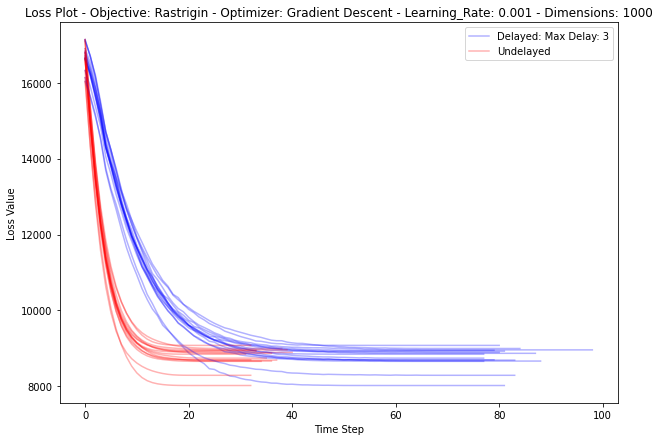

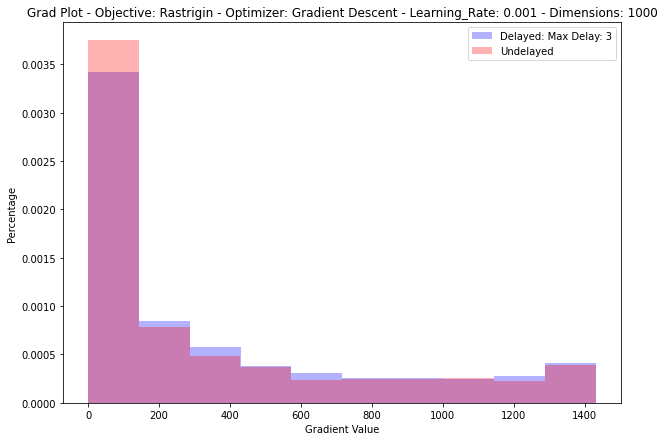

In [4]:
#initial variables
learning_rate = 0.001
loss_name = "Rastrigin"
max_delay = 3
dim = 1000
optimizer = 'gradient'
const_lr = True
#generate the initial values
X_init = np.random.uniform(-5.12,5.12,size=(15,dim))
loss_results, grad_results, optimizer_name = run_test(X_init, loss_name = loss_name,
                                                      learning_rate = learning_rate,
                                                      optimizer = optimizer,
                                                      dim = dim, max_delay = max_delay,
                                                      const_lr = const_lr)
plot_results(loss_results, grad_results, loss_name, optimizer_name, 
             dim, max_delay, learning_rate)

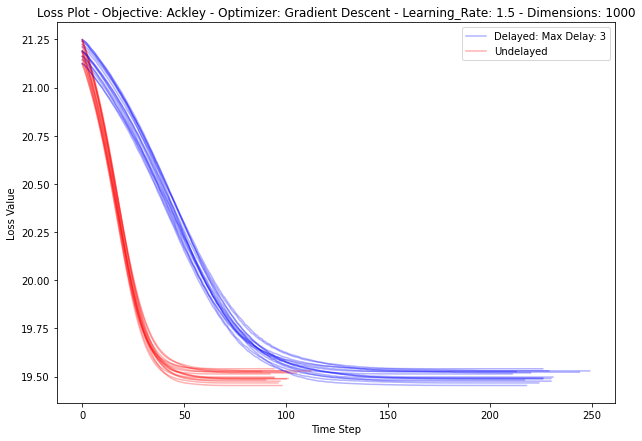

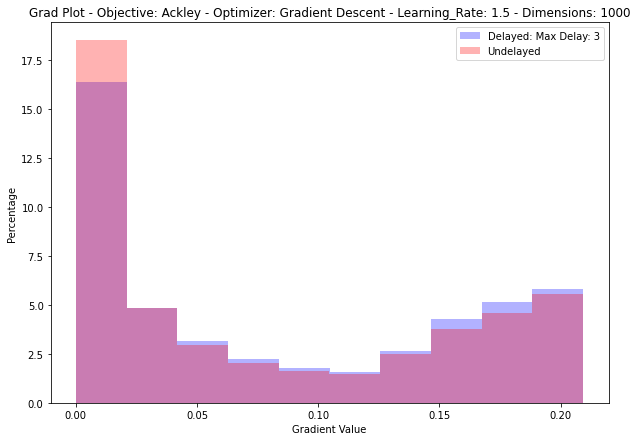

In [5]:
#initial variables
learning_rate = 1.5
loss_name = "Ackley"
max_delay = 3
dim = 1000
optimizer = 'gradient'
const_lr = True
#generate the initial values
X_init = np.random.uniform(-32.,32.,size=(15,dim))
loss_results, grad_results, optimizer_name = run_test(X_init, loss_name = loss_name,
                                                      learning_rate = learning_rate,
                                                      optimizer = optimizer,
                                                      dim = dim, max_delay = max_delay,
                                                      const_lr = const_lr)
plot_results(loss_results, grad_results, loss_name, optimizer_name, 
             dim, max_delay, learning_rate)

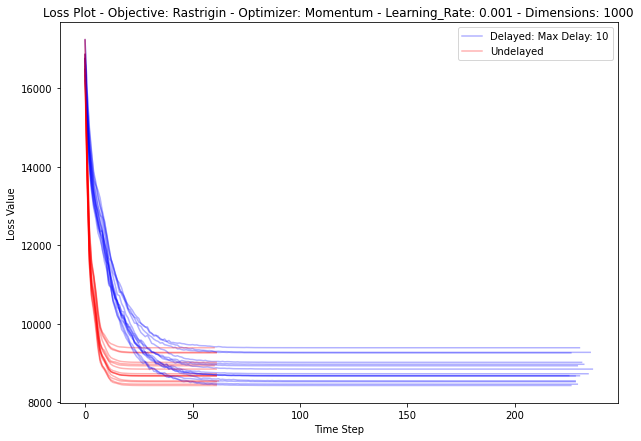

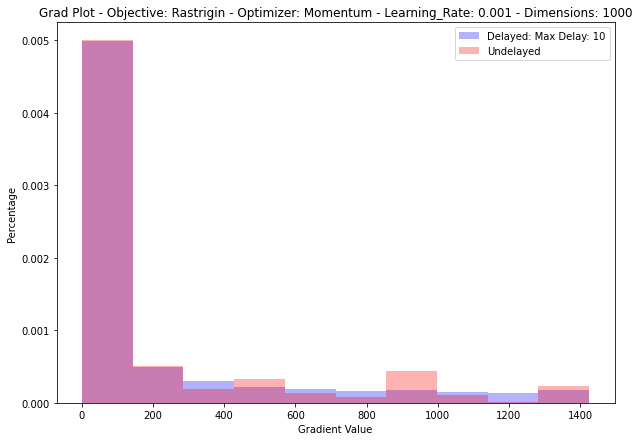

In [10]:
#initial variables
learning_rate = 0.001
loss_name = "Rastrigin"
max_delay = 10
dim = 1000
optimizer = 'momentum'
optim_params = {'gamma': 0.7}
const_lr = True
#generate the initial values
X_init = np.random.uniform(-5.12,5.12,size=(15,dim))
loss_results, grad_results, optimizer_name = run_test(X_init, loss_name = loss_name,
                                                      learning_rate = learning_rate,
                                                      optimizer = optimizer,
                                                      dim = dim, max_delay = max_delay,
                                                      const_lr = const_lr,
                                                      optim_params = optim_params)
plot_results(loss_results, grad_results, loss_name, optimizer_name, 
             dim, max_delay, learning_rate)

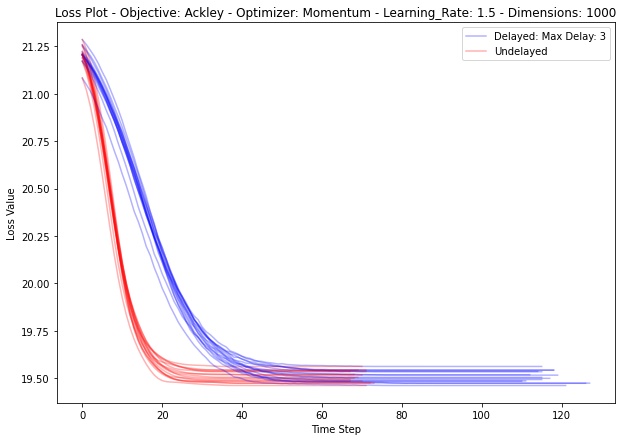

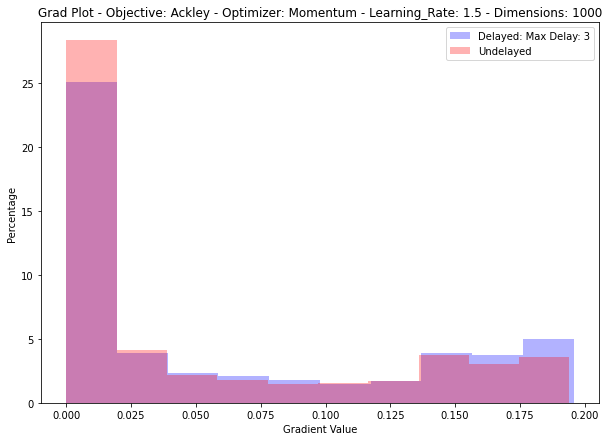

In [7]:
#initial variables
learning_rate = 1.5
loss_name = "Ackley"
max_delay = 3
dim = 1000
optimizer = 'momentum'
optim_params = {'gamma': 0.7}
const_lr = True
#generate the initial values
X_init = np.random.uniform(-32.,32.,size=(15,dim))
loss_results, grad_results, optimizer_name = run_test(X_init, loss_name = loss_name,
                                                      learning_rate = learning_rate,
                                                      optimizer = optimizer,
                                                      dim = dim, max_delay = max_delay,
                                                      const_lr = const_lr,
                                                      optim_params = optim_params)
plot_results(loss_results, grad_results, loss_name, optimizer_name, 
             dim, max_delay, learning_rate)

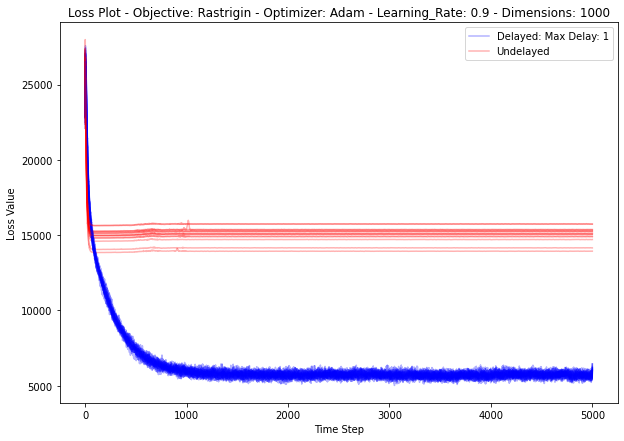

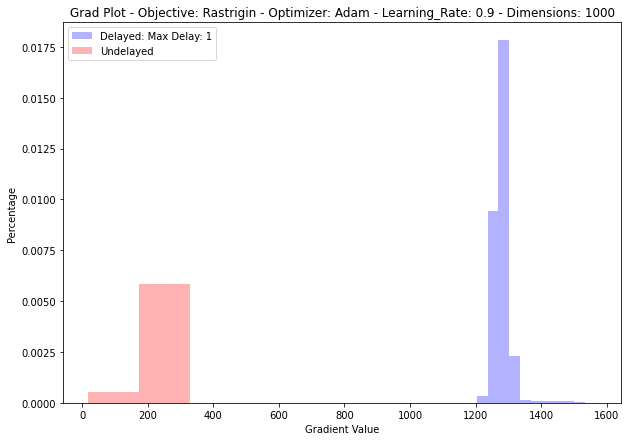

In [8]:
#initial variables
learning_rate = 0.9
loss_name = "Rastrigin"
max_delay = 1
dim = 1000
optimizer = 'adam'
optim_params = {'beta_1': 0.9, 'beta_2': 0.999}
const_lr = True
#generate the initial values
X_init = np.random.uniform(-5.12,5.12,size=(15,dim))
loss_results, grad_results, optimizer_name = run_test(X_init, loss_name = loss_name,
                                                      learning_rate = learning_rate,
                                                      optimizer = optimizer,
                                                      dim = dim, max_delay = max_delay,
                                                      const_lr = const_lr,
                                                      optim_params = optim_params)
plot_results(loss_results, grad_results, loss_name, optimizer_name, 
             dim, max_delay, learning_rate)

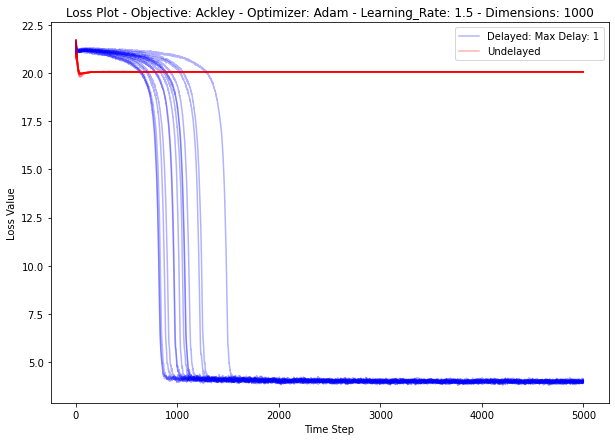

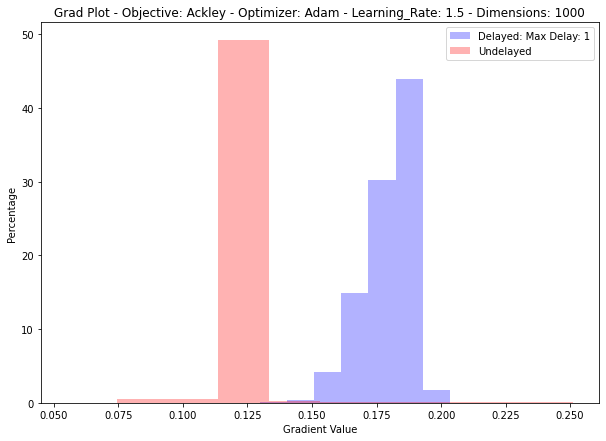

In [9]:
#initial variables
learning_rate = 1.5
loss_name = "Ackley"
max_delay = 1
dim = 1000
optimizer = 'adam'
optim_params = {'beta_1': 0.9, 'beta_2': 0.999}
const_lr = True
#generate the initial values
X_init = np.random.uniform(-32.,32.,size=(15,dim))
loss_results, grad_results, optimizer_name = run_test(X_init, loss_name = loss_name,
                                                      learning_rate = learning_rate,
                                                      optimizer = optimizer,
                                                      dim = dim, max_delay = max_delay,
                                                      const_lr = const_lr,
                                                      optim_params = optim_params)
plot_results(loss_results, grad_results, loss_name, optimizer_name, 
             dim, max_delay, learning_rate)